# Compare spectra at different ages with python-fsps

- adapted by SDC from https://dfm.io/python-fsps/current/stellarpop_api/#example
-  CCIN2P3 CPU
- conda environnment : conda_prospector_py310
- and conda_jax0325_py310 on GPU
- creation date : 2023/10/05
- last update  : 2023/10/05


Lets start by initializing a simple stellar population with solar metallicity and some dust with a Calzetti et al (2000) extinction curve:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.backends.backend_pdf import PdfPages
import copy

In [2]:
import numpy as np

In [3]:
from astropy.cosmology import FlatLambdaCDM

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
# two mutually exclusive flags to see if we can provide SFR for t> tobs
# both flags can be True of False at the same time, but no selection on tobs will be done
FLAG_CUT_BELOW_TOBS = True
FLAG_CUT_AFTER_TOBS = False
FLAG_SET_YLIM = True

## Example

In [6]:
import fsps

sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1,sfh=0, logzsol=0.0, dust_type=2, dust2=0.0)

sp.libraries

(b'mist', b'miles', b'DL07  ')

The last line indicates that we are using the MIST isochrones and MILES spectral library. These can be changed only by reinstalling python-FSPS with appropriate flags.

Let’s get the AB magnitudes in SDSS bands, for a simple stellar population (SSP) that is 13.7 Gyr old:

Now we can change a parameter (say, lower the metallicity) and get a new set of magnitudes:

In [7]:
sp.params['logzsol'] = -1

We can also get the spectrum, here in units of $L_{\odot}/Hz$ , as well as the total stellar mass formed by 13.7 Gyr and the surviving stellar mass at 13.7 Gyr (both in units of ):

In [8]:
gal_t_table = np.linspace(0.05, 13.8, 50) # age of the universe in Gyr
gal_lgmet = sp.params['logzsol']
# must put a true SFR using package diffstar
gal_sfr_table = np.zeros(len(gal_t_table)) # SFR in Msun/yr

In [9]:
NBSPECTRA = len(gal_t_table)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [10]:
# defining the list of redshits/tobs
all_redshifts = np.array([0., 0.1, 0.5, 1.0, 3., 5.])
all_ages = cosmo.age(all_redshifts)

In [11]:
all_ages

<Quantity [13.46698395, 12.16568639,  8.42634602,  5.75164694,  2.11252719,
            1.15475791] Gyr>

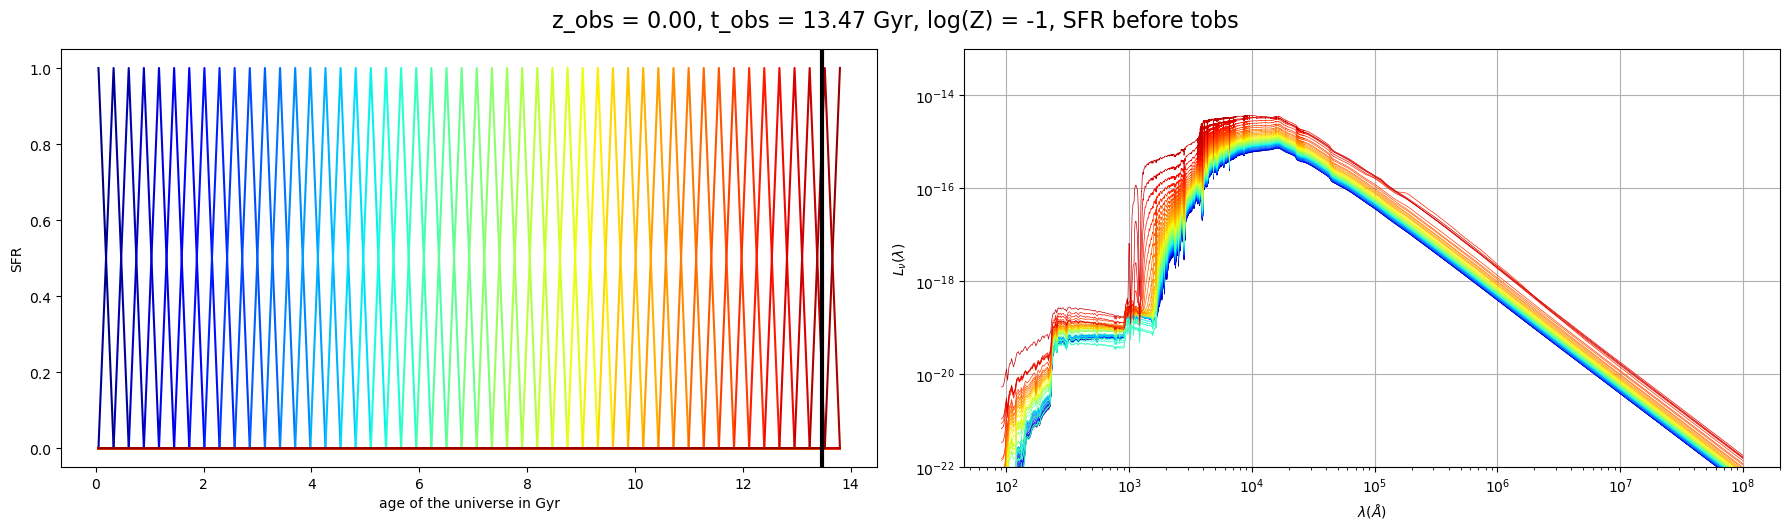

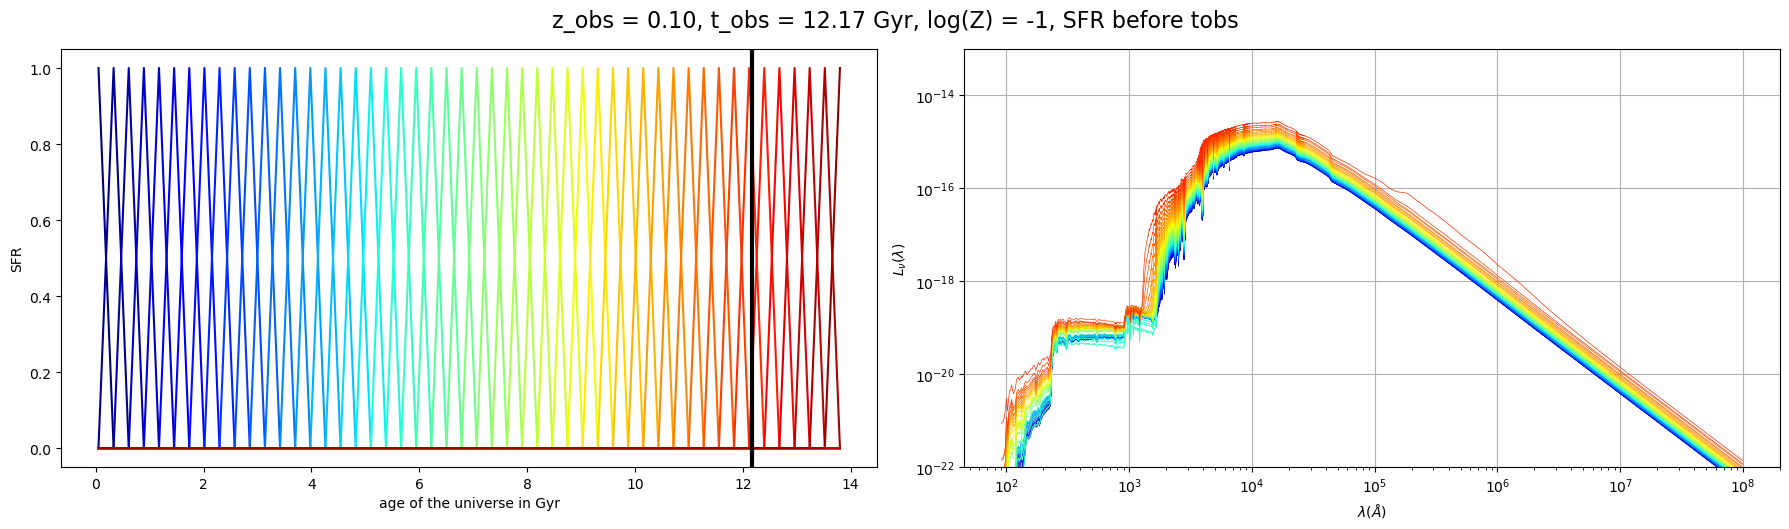

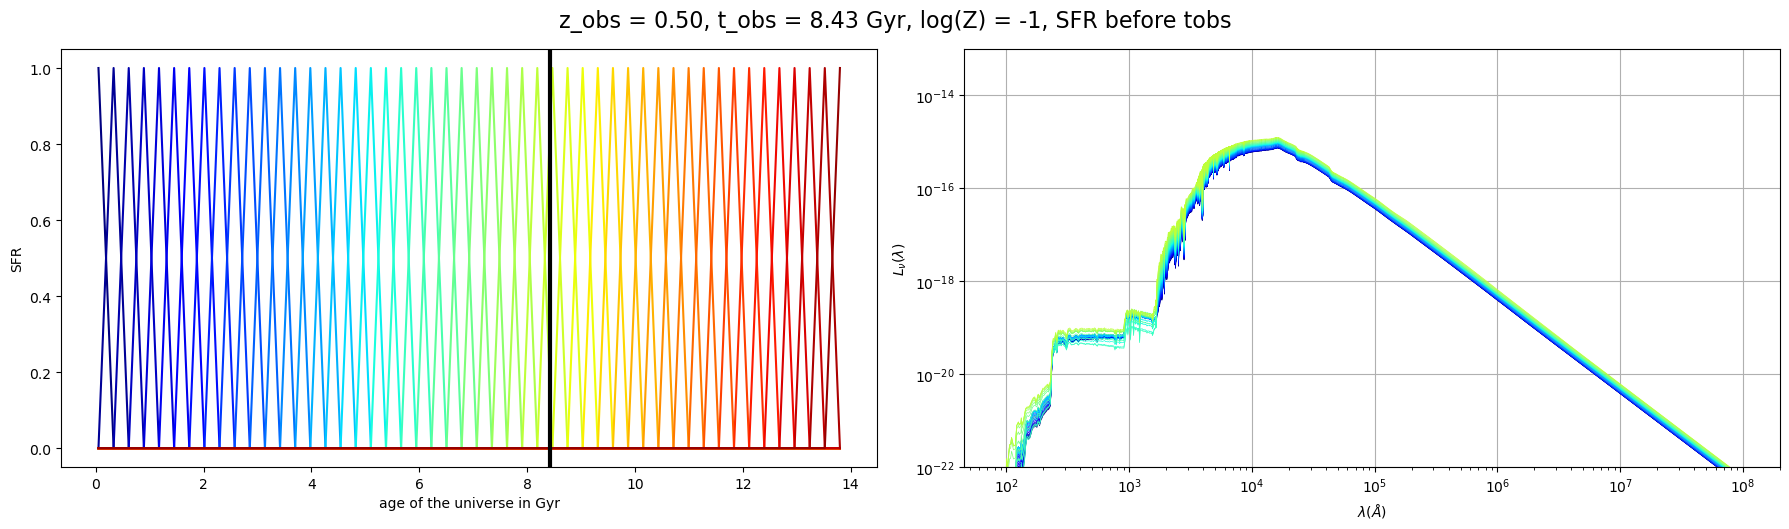

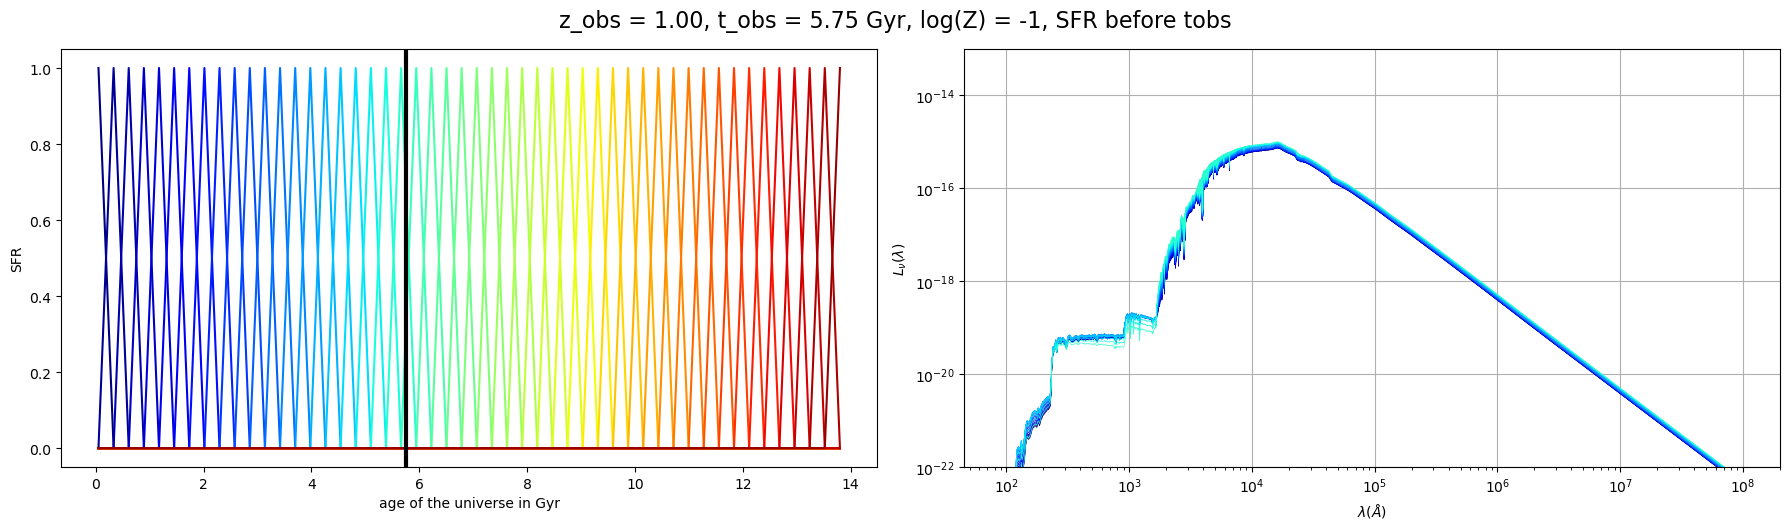

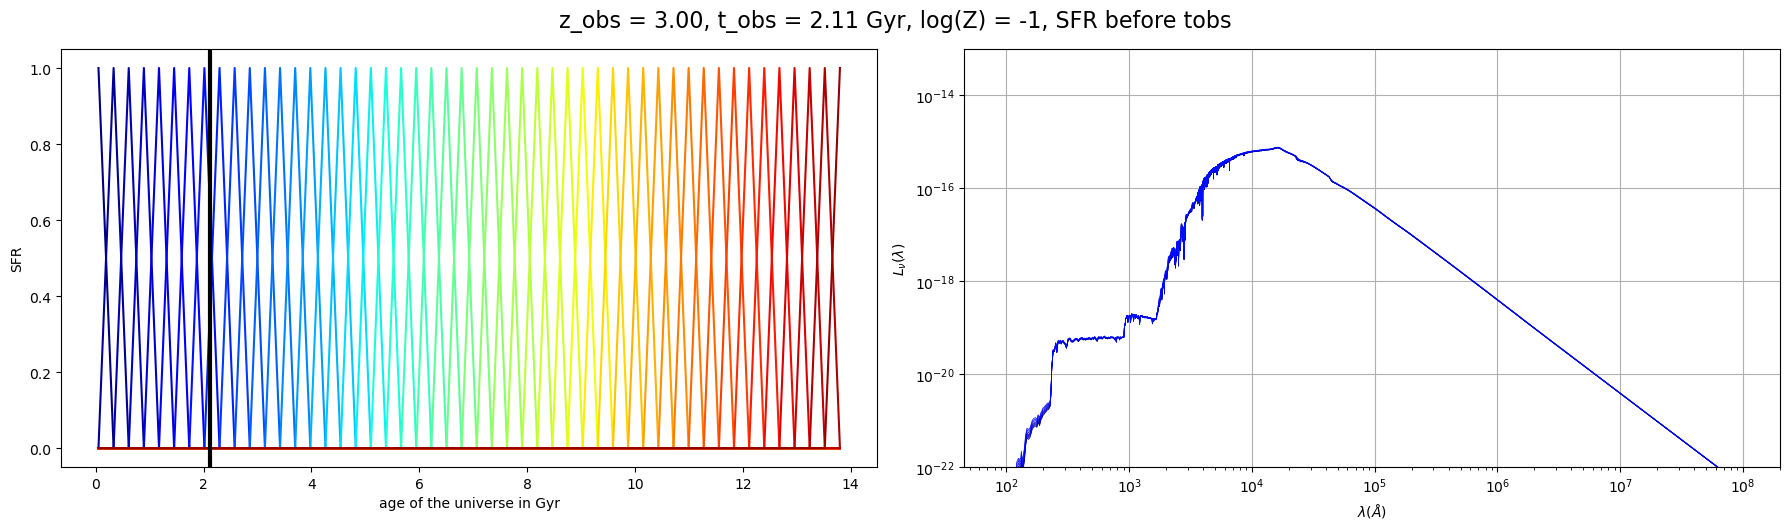

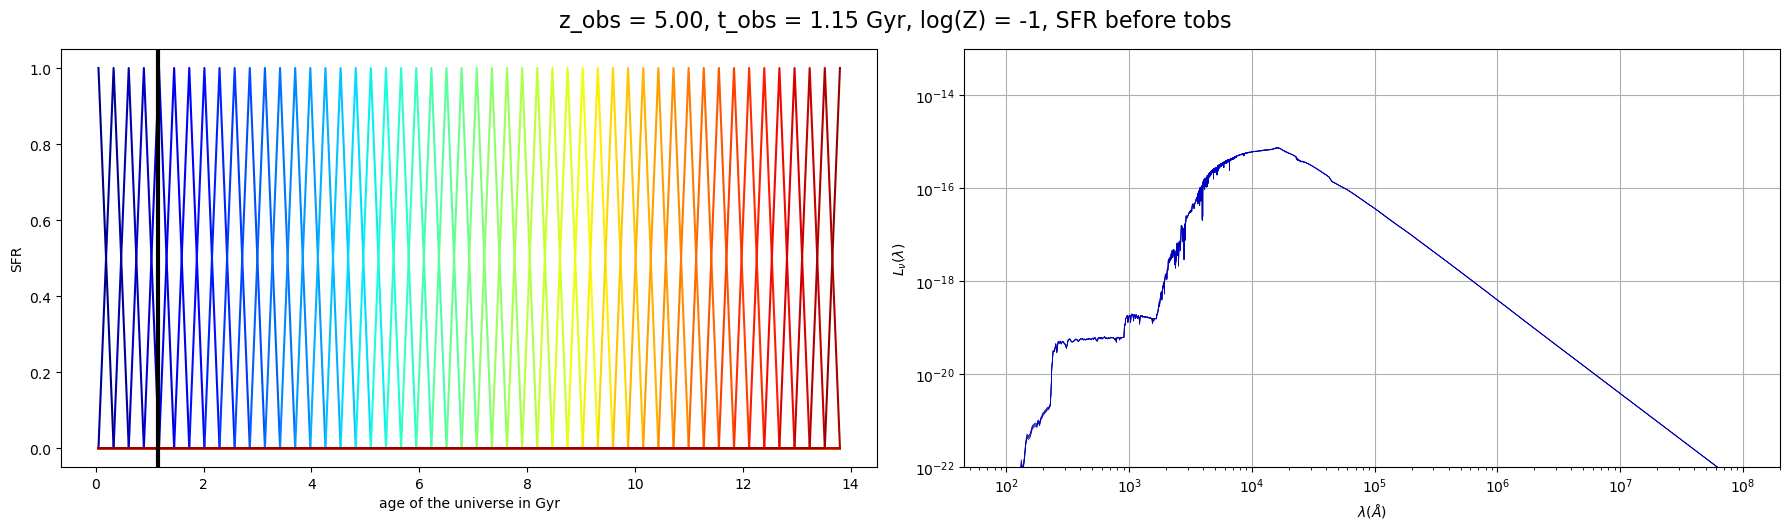

In [12]:
# empty containers to start
all_sed_for_allredshifts = []
all_wl_forallredshifts = []
all_sedtitles_for_allredshifts = []
all_sedtobs = []


for index,redshift in enumerate(all_redshifts):
    
    # info
    # =====
    z_obs = redshift
    t_obs = all_ages[index].value # age of the universe in Gyr at z_obs
    
    if FLAG_CUT_BELOW_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR before tobs"
    elif FLAG_CUT_AFTER_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR after tobs"
    elif FLAG_CUT_AFTER_TOBS ==  FLAG_CUT_BELOW_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR before and after tobs"
    
    # save title and tobs for that redshift
    all_sedtitles_for_allredshifts.append(the_title)
    all_sedtobs.append(t_obs)
    
    # Compute spectra
    # ==============
    all_sed  = []
    all_wl = []
    all_sfr = []

    # loop on ages
    for idx,time in enumerate(gal_t_table):
        
        gal_sfr_table[idx] = 1.0
        all_sfr.append(copy.deepcopy(gal_sfr_table))
              
        wave, spec = sp.get_spectrum(tage=13.8-time)
       
        all_sed.append(spec)
        all_wl.append(wave)
    
        gal_sfr_table[idx] = 0.0
    
    # Save all SED infos for that redshift
    all_sed_for_allredshifts.append(copy.deepcopy(all_sed))
    all_wl_forallredshifts.append(all_wl)
    
    # Plot
    #=====
    fig, axs = plt.subplots(1, 2,figsize=(18,5))

    ax1=axs[0]
    for idx,time in enumerate(gal_t_table):
        ax1.plot(gal_t_table, all_sfr[idx],"-",color=all_colors[idx])
    ax1.set_xlabel("age of the universe in Gyr")
    ax1.set_ylabel("SFR")
    ax1.axvline(t_obs,color="k",lw=3)

    ax2=axs[1]
    __=ax2.loglog()
    
    all_sedinrestframe = []
    for idx,time in enumerate(gal_t_table):
        if FLAG_CUT_BELOW_TOBS and time < t_obs:
            ax2.plot(all_wl[idx], all_sed[idx],"-",color=all_colors[idx],lw=0.5)
           
        elif FLAG_CUT_AFTER_TOBS and time > t_obs:
            ax2.plot(all_wl[idx], all_sed[idx],"-",color=all_colors[idx],lw=0.5)
           
        elif FLAG_CUT_BELOW_TOBS == FLAG_CUT_AFTER_TOBS:
            ax2.plot(all_wl[idx], all_sed[idx],"-",color=all_colors[idx],lw=0.5)

            

    if FLAG_SET_YLIM:
        ax2.set_ylim(1e-22,1e-13)
    ax2.grid()
    ax2.set_xlabel("$\lambda (\\AA)$")
    ax2.set_ylabel("$L_\\nu(\lambda)$")
    
    
    plt.tight_layout()
    plt.suptitle(the_title,y=1.05,fontsize=16)
    

It is highly recommended that only one instance of fsps.StellarPopulation be used in a given program.

## Example using nebular emission

We initialize a simple stellar population and set the flag to include nebular emission:

In [17]:
sp = fsps.StellarPopulation(zcontinuous=1,add_neb_emission=1)

We can change the stellar metallicity, the gas phase metallicity, the gas ionization parameter, and then return the total spectrum at 1 Myr:

In [18]:
sp.params['logzsol'] = -1.0
sp.params['gas_logz'] = -1.0
sp.params['gas_logu'] = -2.5

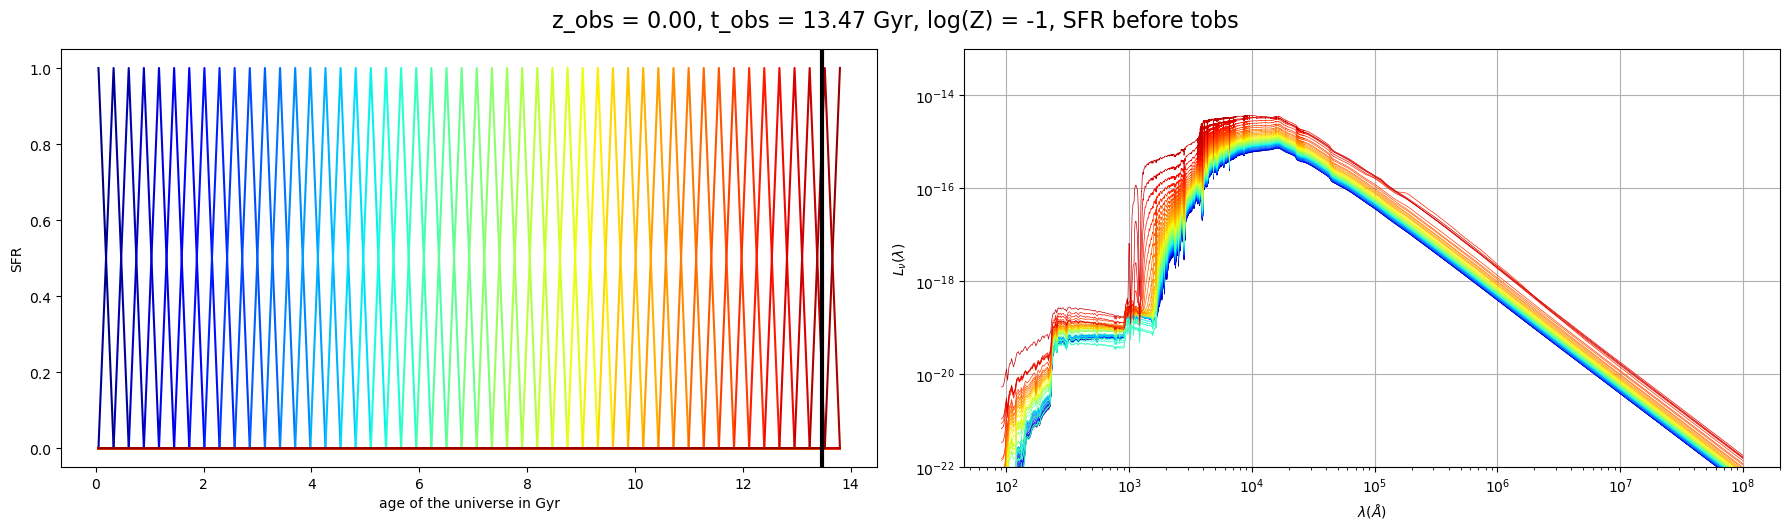

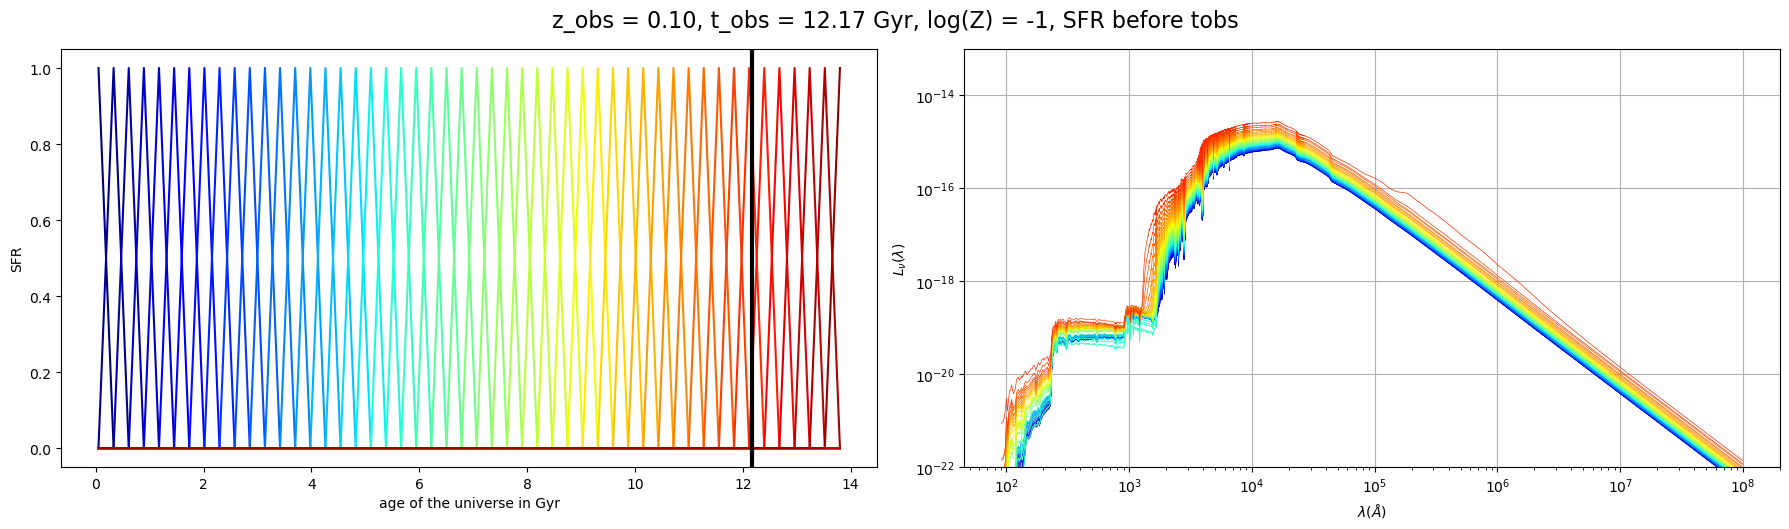

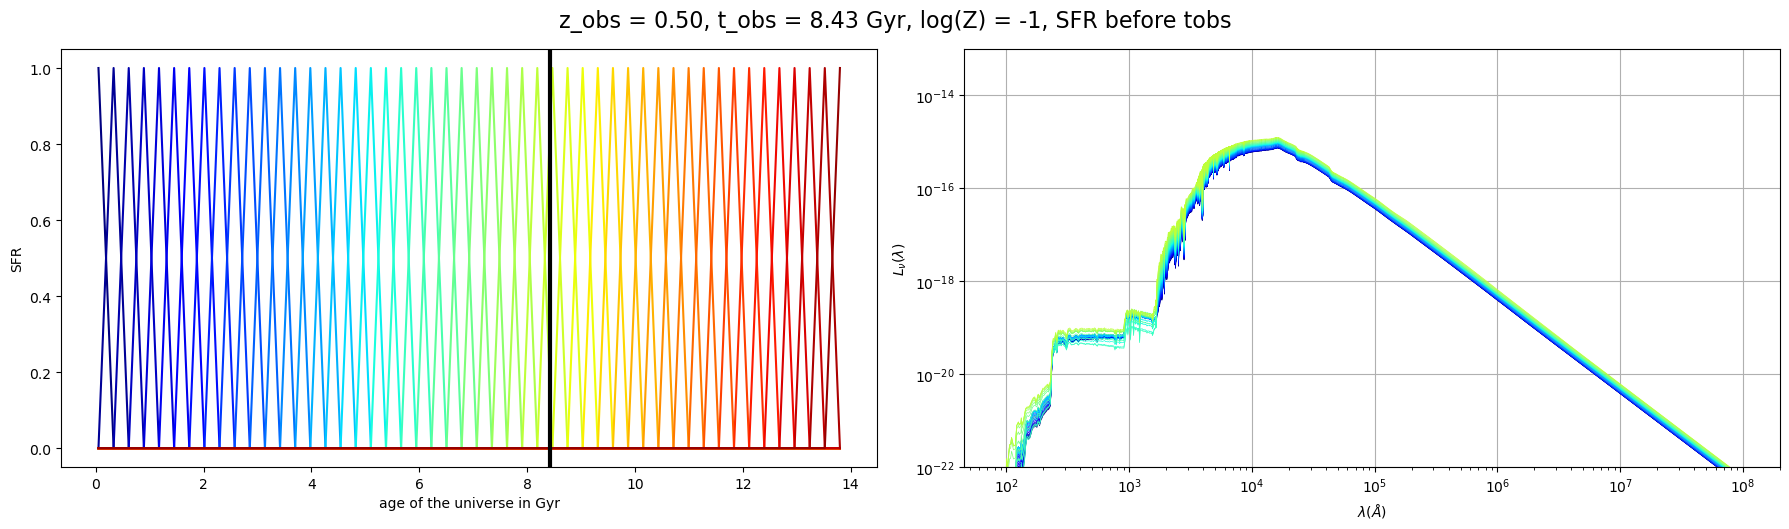

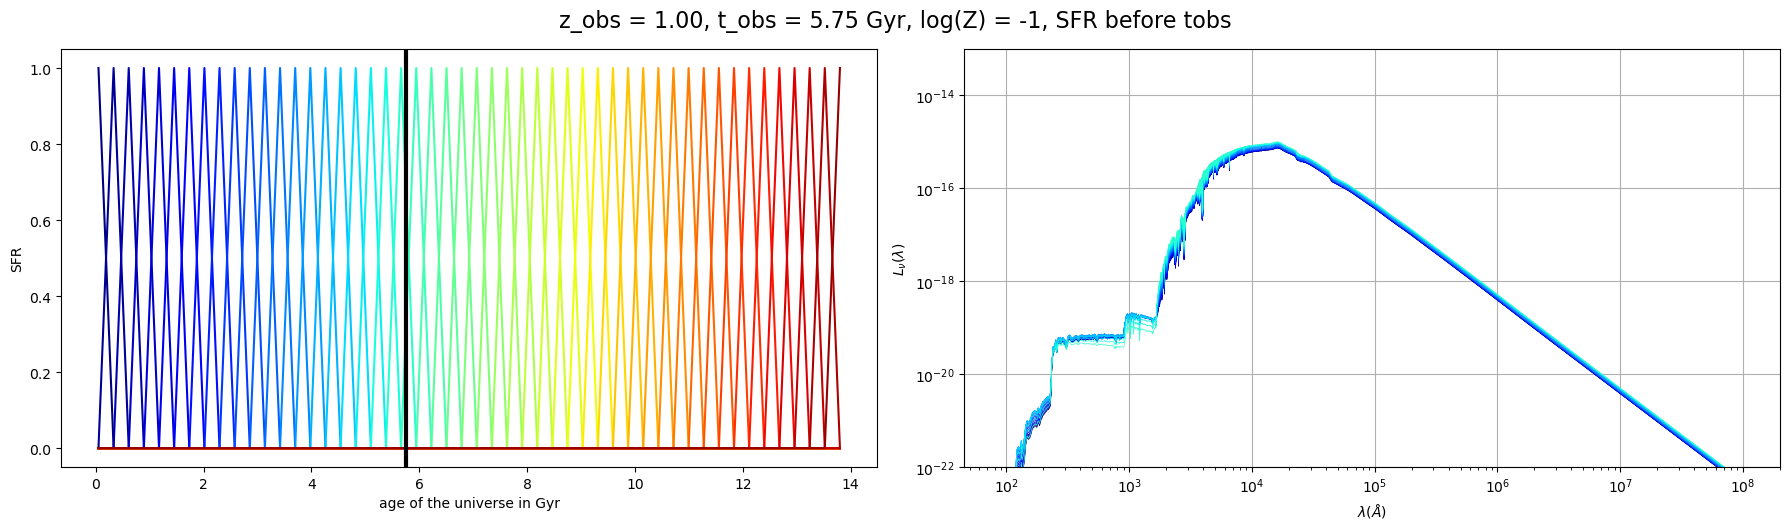

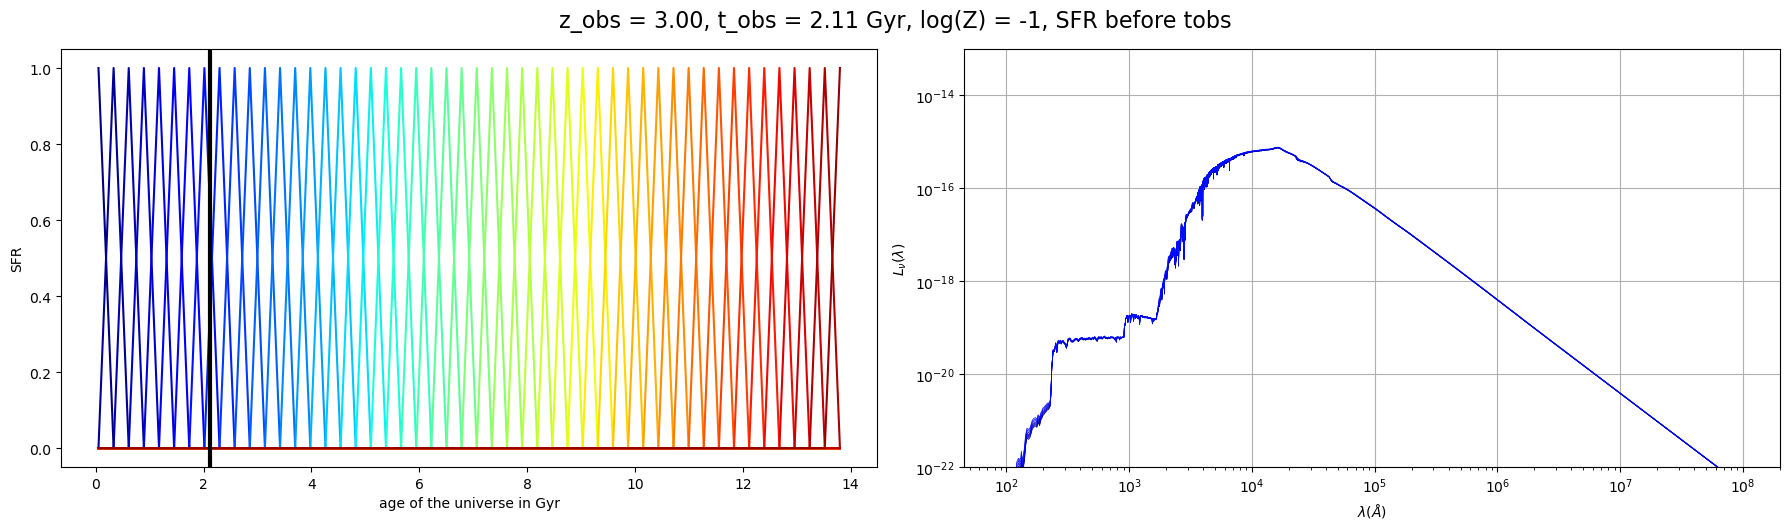

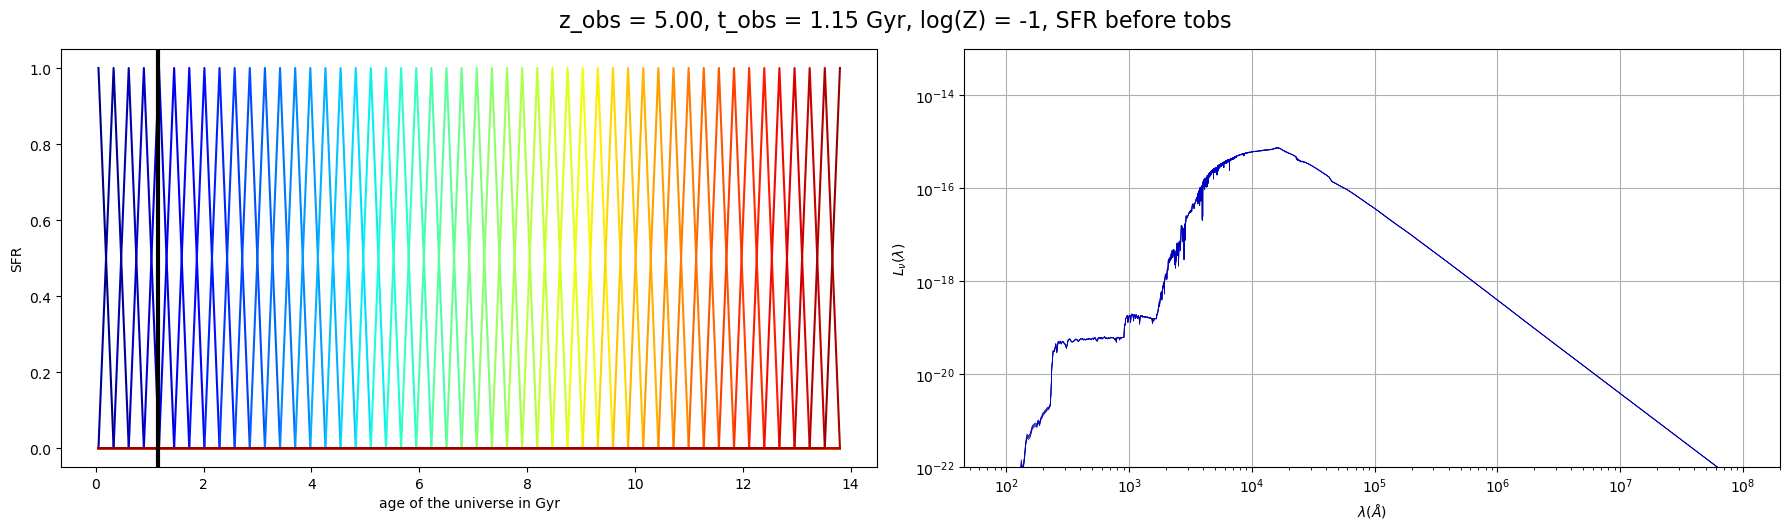

In [19]:
# empty containers to start
all_sed_for_allredshifts = []
all_wl_forallredshifts = []
all_sedtitles_for_allredshifts = []
all_sedtobs = []


for index,redshift in enumerate(all_redshifts):
    
    # info
    # =====
    z_obs = redshift
    t_obs = all_ages[index].value # age of the universe in Gyr at z_obs
    
    if FLAG_CUT_BELOW_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR before tobs"
    elif FLAG_CUT_AFTER_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR after tobs"
    elif FLAG_CUT_AFTER_TOBS ==  FLAG_CUT_BELOW_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR before and after tobs"
    
    # save title and tobs for that redshift
    all_sedtitles_for_allredshifts.append(the_title)
    all_sedtobs.append(t_obs)
    
    # Compute spectra
    # ==============
    all_sed  = []
    all_wl = []
    all_sfr = []

    # loop on ages
    for idx,time in enumerate(gal_t_table):
        
        gal_sfr_table[idx] = 1.0
        all_sfr.append(copy.deepcopy(gal_sfr_table))
              
        wave, spec = sp.get_spectrum(tage=13.8-time)
       
        all_sed.append(spec)
        all_wl.append(wave)
    
        gal_sfr_table[idx] = 0.0
    
    # Save all SED infos for that redshift
    all_sed_for_allredshifts.append(copy.deepcopy(all_sed))
    all_wl_forallredshifts.append(all_wl)
    
    # Plot
    #=====
    fig, axs = plt.subplots(1, 2,figsize=(18,5))

    ax1=axs[0]
    for idx,time in enumerate(gal_t_table):
        ax1.plot(gal_t_table, all_sfr[idx],"-",color=all_colors[idx])
    ax1.set_xlabel("age of the universe in Gyr")
    ax1.set_ylabel("SFR")
    ax1.axvline(t_obs,color="k",lw=3)

    ax2=axs[1]
    __=ax2.loglog()
    
    all_sedinrestframe = []
    for idx,time in enumerate(gal_t_table):
        if FLAG_CUT_BELOW_TOBS and time < t_obs:
            ax2.plot(all_wl[idx], all_sed[idx],"-",color=all_colors[idx],lw=0.5)
           
        elif FLAG_CUT_AFTER_TOBS and time > t_obs:
            ax2.plot(all_wl[idx], all_sed[idx],"-",color=all_colors[idx],lw=0.5)
           
        elif FLAG_CUT_BELOW_TOBS == FLAG_CUT_AFTER_TOBS:
            ax2.plot(all_wl[idx], all_sed[idx],"-",color=all_colors[idx],lw=0.5)

            

    if FLAG_SET_YLIM:
        ax2.set_ylim(1e-22,1e-13)
    ax2.grid()
    ax2.set_xlabel("$\lambda (\\AA)$")
    ax2.set_ylabel("$L_\\nu(\lambda)$")
    
    
    plt.tight_layout()
    plt.suptitle(the_title,y=1.05,fontsize=16)
    

Note: for the nebular model to be fully self-consistent, the gas phase metallicity and the stellar metallicity should be set to the same value. This effectively adds the emission spectrum to the same stellar spectrum that was used as the ionizing spectrum in Cloudy. If users choose to vary the gas phase metallicity at constant stellar metallicity, expect non-hydrogenic emission lines to be accurate within 1-15%.

Emission line wavelengths and line luminosities can be accessed through the stellar population object:

In [39]:
all_tage = [0.001,0.01,0.1,1.,10]
NBSPECTRA = len(all_tage)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

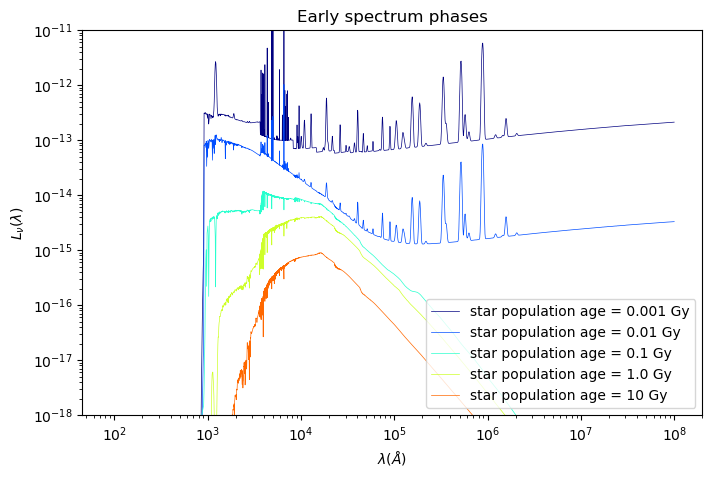

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
__=ax.loglog()

for idx,tage in enumerate(all_tage):
    wave, spec = sp.get_spectrum(tage=tage)
    label = f"star population age = {tage} Gy"
    ax.plot(wave,spec,'-',lw=0.5,color=all_colors[idx],label=label)
if FLAG_SET_YLIM:
    ax.set_ylim(1e-18,1e-11)
ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\nu(\lambda)$")
    
ax.set_title("Early spectrum phases")
ax.legend()

Text(0.5, 1.0, 'Emission lines')

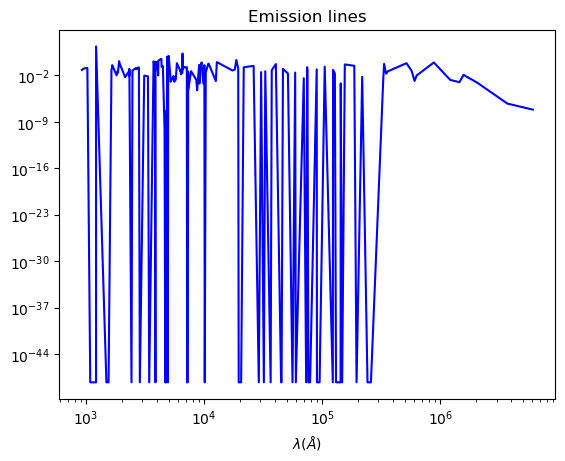

In [28]:
#print(sp.emline_wavelengths)
#print(sp.emline_luminosity)

fig, ax = plt.subplots()
ax.loglog(sp.emline_wavelengths,sp.emline_luminosity,'b-')
#ax.set_ylim(1e-15,1e-11)
ax.set_xlabel("$\lambda (\\AA)$")
ax.set_title("Emission lines")